## Case-Study: Maintenance Communities within the RNV network


The RNV (Rhein-Neckar-Verkehr GmbH) wants to improve its ability to respond to break-downs in their transportation network by reorganizing their service and maintenance organization. The current plan is to replace the single maintenance team for the entire network with three maintenance teams, each responsible for a small set of stops in the RNV network.

Your objective is to propose three sets of stops to the RNV that will enable them to create the three maintenance teams they plan to implement. Each set of stops should be assigned to a different maintenance team to ensure that the RNV network can be properly maintained and serviced.

![rnv_graph.png](https://drive.google.com/uc?id=1lQnbnIscBtmVw5R-vrX2ijaxa9xWUxCh)

The RNV network contains tram stops and their connections in the network. Each stop is represented by a node, and the connections between them are represented by edges.
The network was created based on the data from the [RNV open data portal](https://www.opendata-oepnv.de//ht/de/organisation/verkehrsunternehmen/rnv/openrnv/datensaetze?tx_vrrkit_view%5Bdataset_name%5D=soll-fahrplandaten-rnv&tx_vrrkit_view%5Baction%5D=details&tx_vrrkit_view%5Bcontroller%5D=View).


Build a network graph using the tram stop dataset, where each stop is a node, and each connection between stops is an edge.
Visualize the graph.

In [5]:
import networkx as nx
# Load the graph and exclude the weights.
G_rnv = nx.read_edgelist("./rnv_connected_stations.txt", create_using=nx.Graph(), delimiter='\t', data=False)
print('Number of stops (nodes): ', len(G_rnv.nodes))
print('Number of connections (edges): ', len(G_rnv.edges))

Number of stops (nodes):  460
Number of connections (edges):  555


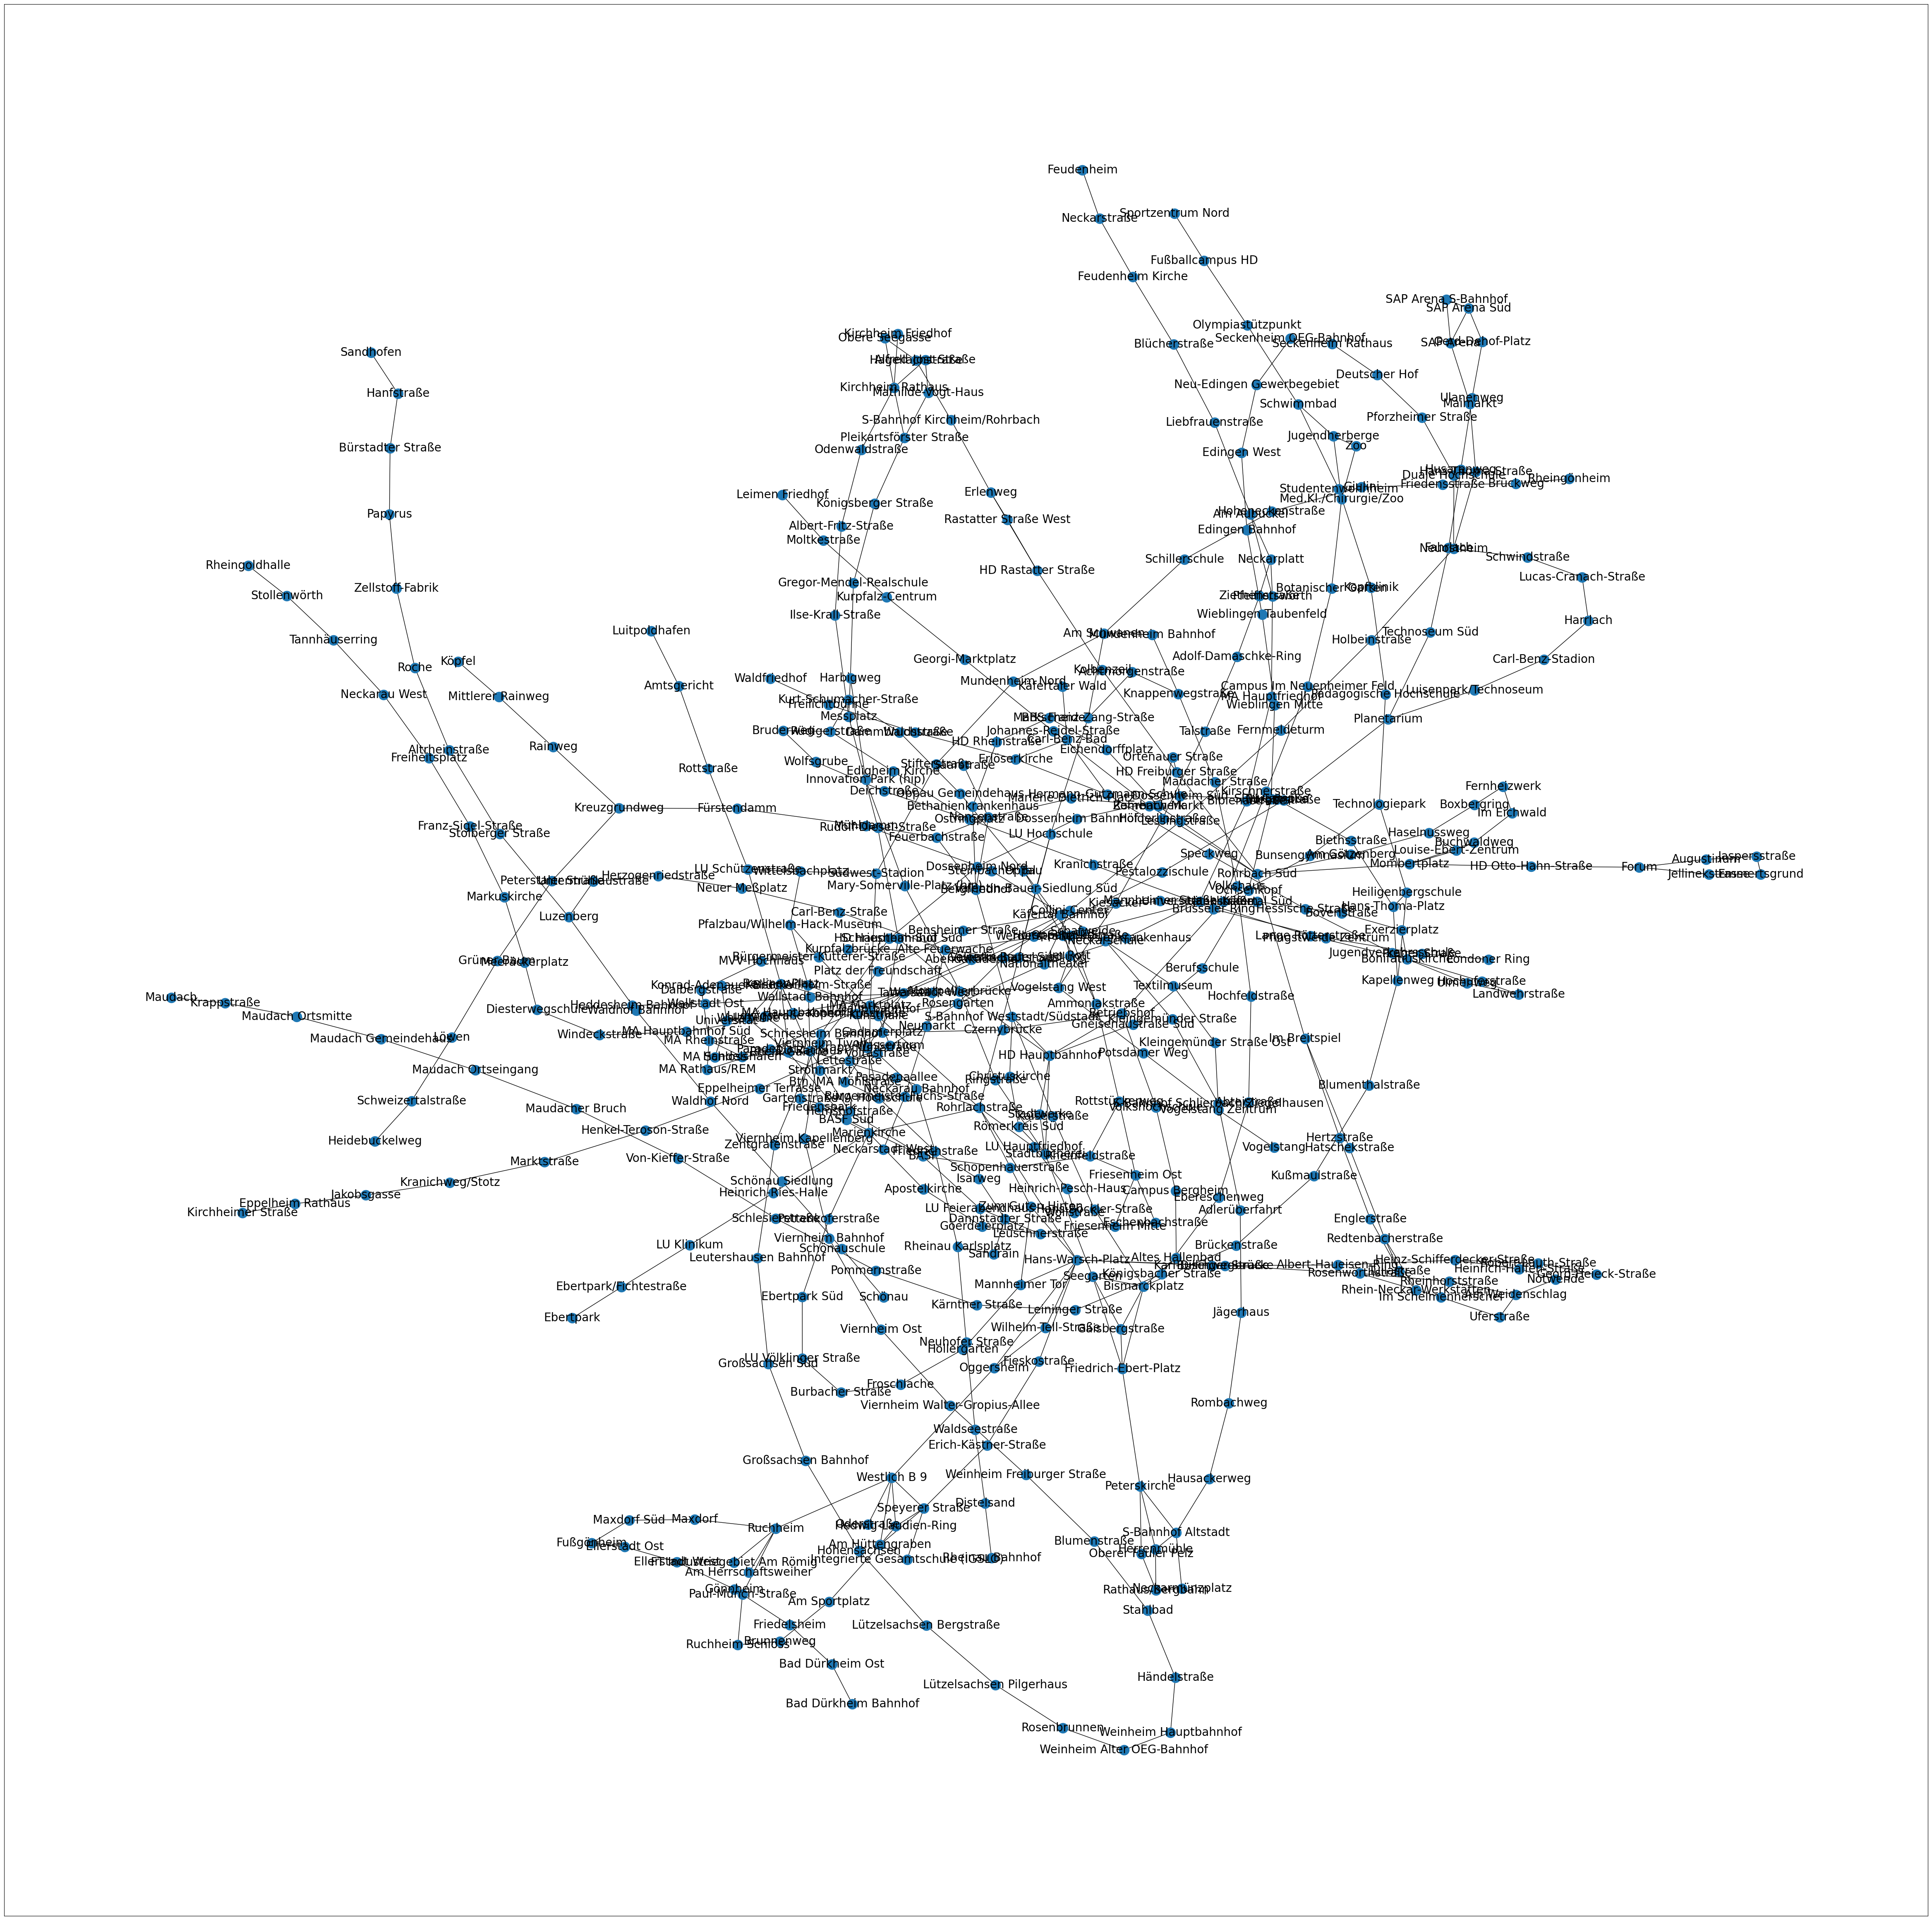

In [5]:
import matplotlib.pyplot as plt

nx.draw_networkx(G_rnv, font_size=20)
fig = plt.gcf()
fig.set_size_inches(60, 60)
plt.show()

## K-Cores

Run the k-cores algorithm to detect communities in the network.
Each stop should be at least connected to 3 other stops.

Visulize the resulting graph and interpret the result.
- Are k-cores a suitable approach for splitting the RNV network into groups of stations that are to be maintained by the different maintenance teams? 
- If not, which methods could deliver better results?

Component:
	 Speyerer Straße
	 Am Hüttengraben
	 Hedwig-Laudien-Ring
	 Westlich B 9

Component:
	 Bismarckplatz
	 Seegarten
	 Friedrich-Ebert-Platz
	 Gaisbergstraße



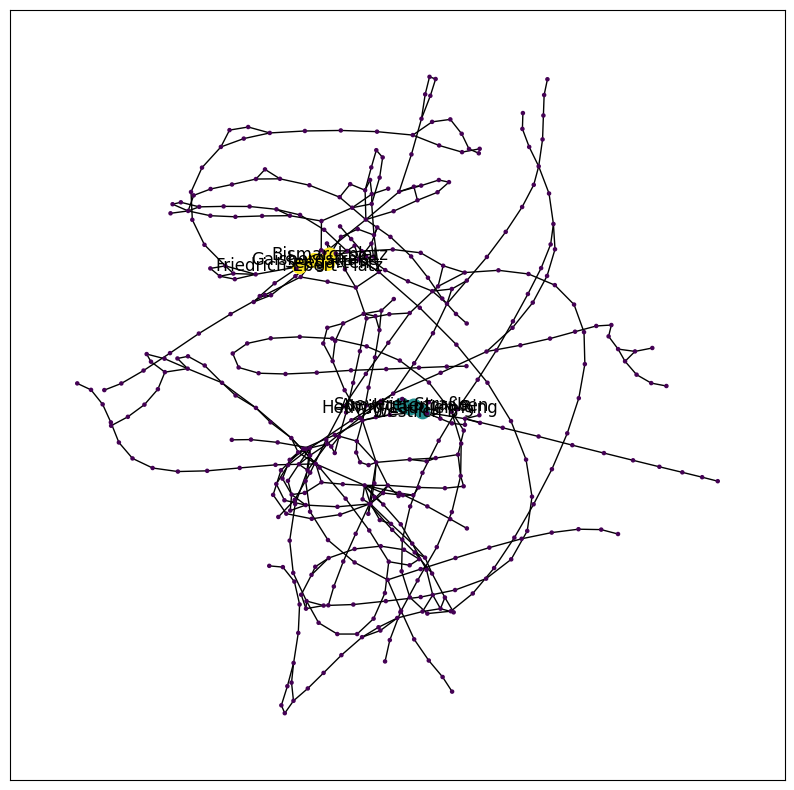

In [8]:
# Use Networkx k_core method with k=3
G_rnv_3_core = nx.k_core(G_rnv, 3)

# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in G_rnv.nodes()}
node_color_dict = {v:5 for v in G_rnv.nodes()}
node_size_dict = {v:5 for v in G_rnv.nodes()}

pos = nx.spring_layout(G_rnv, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(G_rnv_3_core):
    # Change color of nodes with this component
    current_color += 100
    print('Component:')
    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color
        
        print('\t {}'.format(node))
        # Add node label and size for the visualization
        node_label_dict[node] = node
        node_size_dict[node] = 100
    print('')
# Set node size and color of the output network
node_size = [node_size_dict[v] for v in G_rnv.nodes()]
node_color = [node_color_dict[v] for v in G_rnv.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(G_rnv, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict )
plt.show()

K-cores are a type of subgraph in a network where all nodes have at least k connections to other nodes within the subgraph. In the context of the RNV's transportation network, k-cores can be used to identify sets of stops that are highly interconnected. 

Unfortunately, the most stops of the RNV graph are not highly connected, because usually one stop is connected to at most two other stations. k-cores is not helpful in this context. Additionally, we neglect many stops in the network, because they are not added to any component.

## Divisive Hierarchical Clustering

Use divisive clustering to detect communities in the network.
The measure to find strong edges is edge betweenness.

Keep in mind that your goal is to identity 3 maintenance organizations (communitites).

In [6]:
# Divisive Clustering based on Edge Betweenness
G_rnv_clustered = G_rnv.copy()

while(True):
    # Identify "weakest" edge
    top_betweeness_edge_score = sorted(nx.edge_betweenness_centrality(G_rnv_clustered).items(), key=lambda item: item[1], reverse=True)[0]
    top_betweeness_edge = top_betweeness_edge_score[0]
    
    # Remove edge
    G_rnv_clustered.remove_edge(top_betweeness_edge[0], top_betweeness_edge[1])
    
    # Stop removing edges as soon as the graph is split into three components.
    if nx.number_connected_components(G_rnv_clustered) == 3:
        break

print('Number of components: {}'.format(nx.number_connected_components(G_rnv_clustered)))

Number of components: 3


Please visualize the maintenance groups in the graph. 

Each maintenance group needs a depot within their sub-component of the graph.
Determine for each maintenance group the five stops with the highest importance for the reliability of the network in the respective sub-component. A depot can be placed at one of these stops.

Which measure is suitable to determine the importance of a station for the reliability of the network?

Stops with the highest betweeness scores of the component: 
	 Kunsthalle
	 Alte Feuerwache
	 Wasserturm
	 Universitätsklinikum
	 Rosengarten
Stops with the highest betweeness scores of the component: 
	 Rohrlachstraße
	 Westlich B 9
	 LU Hochschule
	 Valentin-Bauer-Siedlung
	 Hans-Warsch-Platz
Stops with the highest betweeness scores of the component: 
	 Jahnstraße
	 HD Hauptbahnhof
	 Betriebshof
	 S-Bahnhof Weststadt/Südstadt
	 Nansenstraße


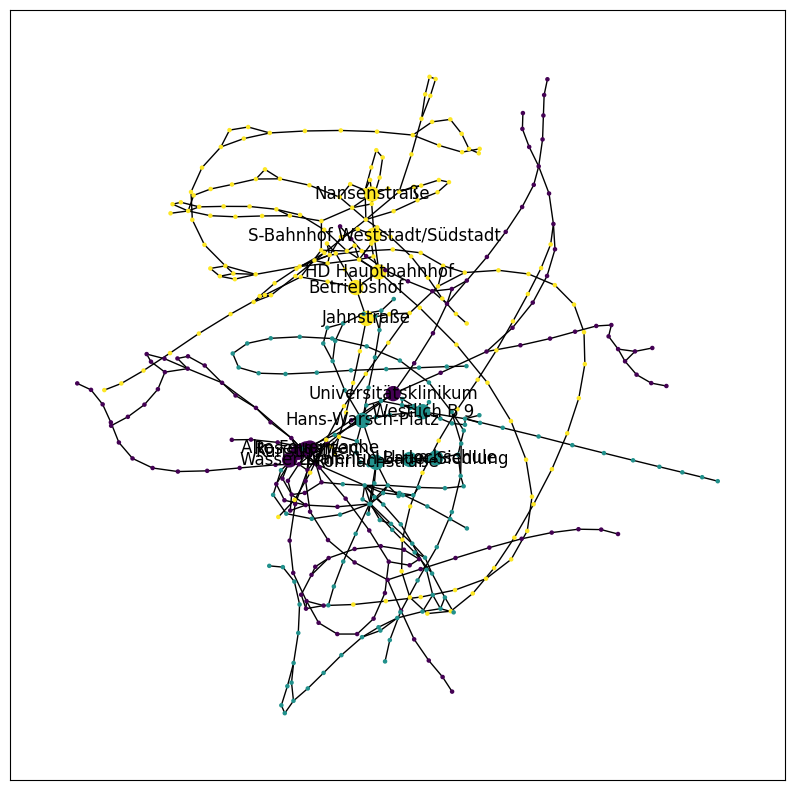

In [7]:
# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in G_rnv.nodes()}
node_color_dict = {v:5 for v in G_rnv.nodes()}
node_size_dict = {v:5 for v in G_rnv.nodes()}

pos = nx.spring_layout(G_rnv, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(G_rnv_clustered):
    # Change color of nodes with this component
    current_color += 100
    print('Stops with the highest betweeness scores of the component: ')
    # Determine subgraph of component and determine stops with the highest betweeness scores
    component_graph = G_rnv_clustered.copy()
    component_graph.remove_nodes_from([n for n in component_graph if n not in set(component)])
    top_betweeness_score_stops = [k for k,v in 
                                  sorted(nx.betweenness_centrality(component_graph, normalized =True).items(), 
                                         key=lambda item: item[1], reverse=True)[:5]]

    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color

        if node in top_betweeness_score_stops:
            print('\t {}'.format(node))
            # Add node label and size for the visualization
            node_label_dict[node] = node
            node_size_dict[node] = 100

# Set node size and color of the output network
node_size = [node_size_dict[v] for v in G_rnv.nodes()]
node_color = [node_color_dict[v] for v in G_rnv.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(G_rnv, pos=pos, with_labels=True,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict )
plt.show()

We were looking for the betweenness score of the stops within the subcomponent.

The result of the divisive clustering technique is great, because it has successfully divided the network into three distinct components. What makes this finding even more fascinating is that each component represents one of the three cities Mannheim, Ludwigshafen, and Heidelberg. The division of the network into these communities is intuitively reasonable and could be highly valuable in helping the RNV reorganize their service and maintenance organization.

## Assignment : Game of Thrones: Network Analysis and community detection 

Your objective is to analyze the Game of Thrones network using the Networkx library, you will find below Datasets of the different books: 

https://github.com/mathbeveridge/asoiaf/tree/master/data 

here some basic tutorials that you can start with: 

https://www.kaggle.com/mmmarchetti/game-of-thrones-network-analysis

https://dzone.com/articles/analyzing-relationships-in-game-of-thrones-with-ne-1

You have the choice to use whatever algorithms you want. However, you must answer a set of questions:

1. What is the most important caracter ?
2. Try multiple centrality measures, how can you interprete the output giving your domain knowledge (I presume that you already watched this serie :))
2. The evolution of Tyrion over the seasons (books)
3. Try multiple community detection algorithms, which one reflect the real communities (houses) in the serie and why ? 
4. ... 4 questions of your choice with a suitable answer 

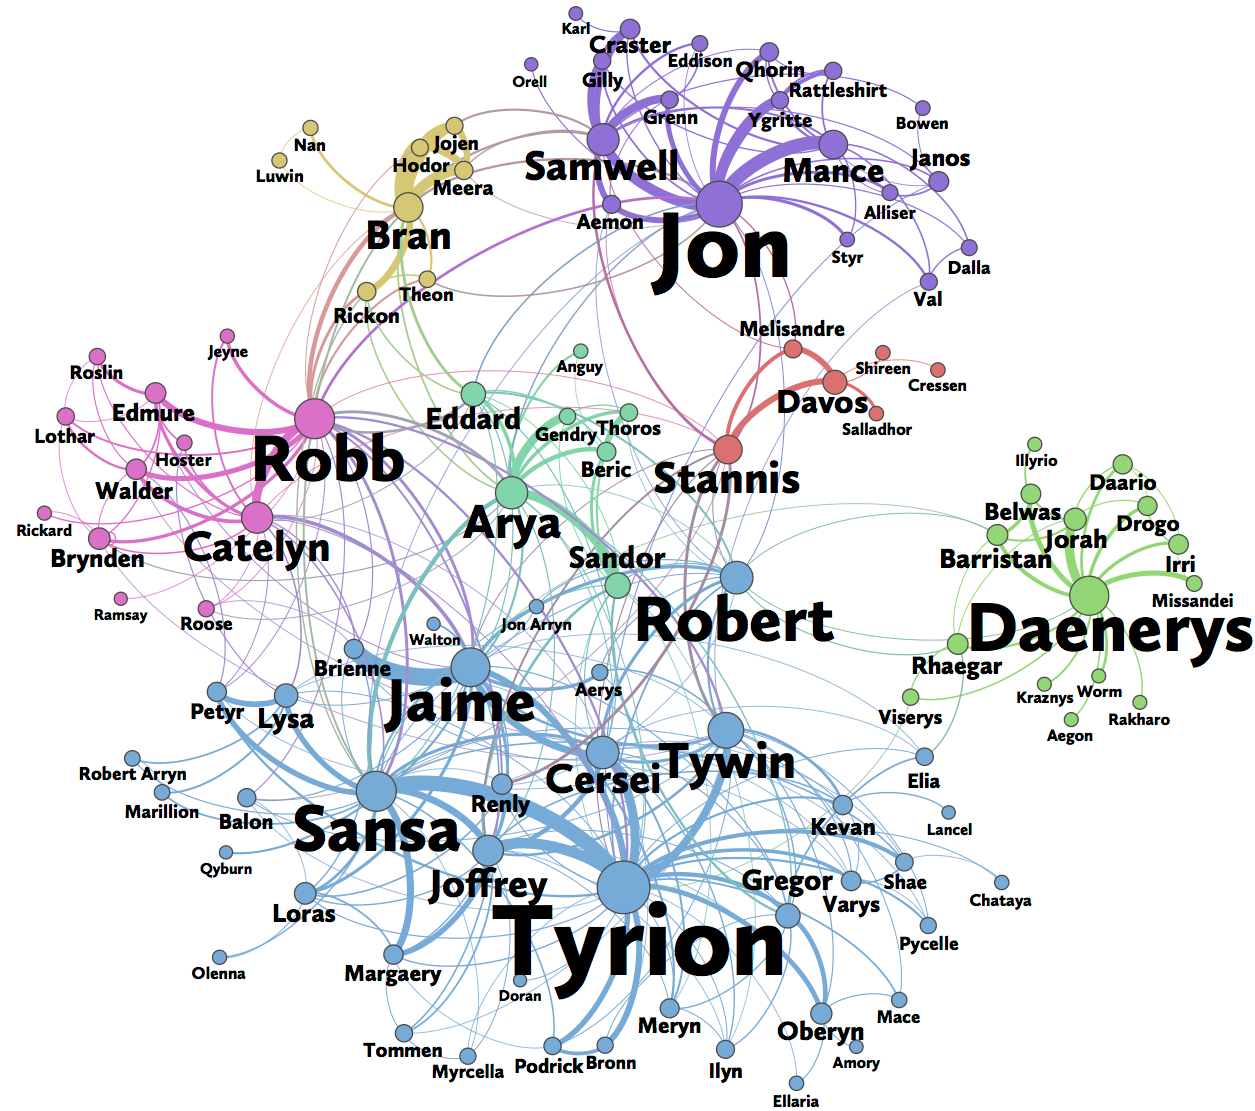

### Question 1 :

In [30]:
import networkx as nx
import pandas as pd

# Load the Game of Thrones network from a CSV file
df = pd.read_csv('got_graph.csv')

# Transform data to a graph
G = nx.from_pandas_edgelist(df, 'Source', 'Target')


# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)



# Find the character with the highest degree centrality
highest_degree_centrality = max(degree_centrality, key=degree_centrality.get)



print(f"The most important character following degree centrality is: {highest_degree_centrality}")

The most important character following degree centrality is: Tyrion-Lannister


Interpretation :

Degree centrality measures the number of connections that a node has in the network, so a character with a
high degree centrality is one who interacts with many other characters in the story. That's why Tyrion Lannister is the perfect answer for degree centrality, because he travaled a lot throught the story in the seven kingdoms, joined a lot of houses and knew a big ammount of characters.

### Question 2 :

In [7]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Find the character with the highest betweenness centrality
highest_betweenness_centrality = max(betweenness_centrality, key=betweenness_centrality.get)

print(f"The most important character by betweenness centrality is: {highest_betweenness_centrality}")

The most important character by betweenness centrality is: Jon-Snow


Interpretation :

Betweenness centrality measures how often a node lies on the shortest path between any two other nodes in a network. In social network terms, it can be seen as the "gatekeeper" in a network, someone who connects different groups or individuals who might not otherwise be connected to each other.
In the GOT universe, Jon Snow has connections to characters from different regions and factions, and is known for his diplomatic skills in negotiating alliances between houses and maintaining peace. Therefore, his position as the top node based on betweenness centrality makes sense, as he plays a key role in connecting different characters and groups in the network, thus he was the reason of the reunion of the North, and also the reason of reunion of the Night Watch and Wildlings.

In [8]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Find the character with the highest closeness centrality
highest_closeness_centrality = max(closeness_centrality, key=closeness_centrality.get)

print(f"The most important character by closeness centrality is: {highest_closeness_centrality}")

The most important character by closeness centrality is: Tyrion-Lannister


Interpretation :

Closeness centrality measures how easily a character can communicate with other characters in the network. A character with high closeness centrality is considered to be closer to other characters in the network, meaning they require fewer steps to reach any other character in the network.
Tyrion has been a part of multiple storylines and has interacted with a wide range of characters from different factions and houses (Stark, Lannister, Arryn, Targaryen, The wall while on exile, Essos with mother of dragons) . Additionally, Tyrion is known for being well-traveled and having knowledge of many different regions, which may have contributed to his ability to connect with characters from different parts of the network.

In [9]:
# Calculate PageRank centrality
pagerank_centrality = nx.pagerank(G)

# Find the character with the highest pagerank centrality
highest_pagerank_centrality = max(betweenness_centrality, key=pagerank_centrality.get)

print(f"The most important character by closeness centrality is: {highest_pagerank_centrality}")

The most important character by closeness centrality is: Jon-Snow


Interpretation :

PageRank centrality is a measure of a node's importance in a network based on the concept of "voting." In a social network, a person is important if they are connected to other important people. Similarly, in PageRank, a node is important if it is linked to other important nodes.
Jon Snow has a high Pagerank centrality because he is connected to many important characters, such as Samwell Tarly, Tyrion Lannister, and Daenerys Targaryen, Sansa Stark and Brandon Stark ( who later will become the three eyed raven around whom the story evolves) who have high centrality themselves. Additionally, Jon Snow is a central character in the story, he is married the queen of dragons, and will discover that he is the legitimate heir of the throne sincve he is the son of Rhaegar Targaryen and L, and his actions have a significant impact on the plot, making him an important node in the network. 

### Question 3 :

In [14]:
book1  = "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book1-edges.csv"
book2  = "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book2-edges.csv"
book3  = "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book3-edges.csv"
book4  = "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book4-edges.csv"
book5  = "https://raw.githubusercontent.com/mathbeveridge/asoiaf/master/data/asoiaf-book5-edges.csv"

data1 = pd.read_csv(book1)
data2 = pd.read_csv(book2)
data3 = pd.read_csv(book3)
data4 = pd.read_csv(book4)
data5 = pd.read_csv(book5)

book1 = nx.Graph()
for _, row in data1.iterrows():
    node1 = row['Source']  
    node2 = row['Target']  
    book1.add_edge(node1, node2)

book2 = nx.Graph()
for _, row in data2.iterrows():
    node1 = row['Source']  
    node2 = row['Target']  
    book2.add_edge(node1, node2)

book3 = nx.Graph()
for _, row in data3.iterrows():
    node1 = row['Source']  
    node2 = row['Target']  
    book3.add_edge(node1, node2)

book4 = nx.Graph()
for _, row in data4.iterrows():
    node1 = row['Source']  
    node2 = row['Target']  
    book4.add_edge(node1, node2)

book5 = nx.Graph()
for _, row in data5.iterrows():
    node1 = row['Source']  
    node2 = row['Target']  
    book5.add_edge(node1, node2)

In [15]:
#degree centrality
list_degree_centrality = []
for graph in [book1, book2, book3, book4, book5]:
  degree_centrality = nx.degree_centrality(graph)
  sorted_keys = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
  rank = sorted_keys.index("Tyrion-Lannister") + 1
  list_degree_centrality.append(rank)

#betweenness centrality
list_betweenness_centrality = []
for graph in [book1, book2, book3, book4, book5]:
  betweenness_centrality = nx.betweenness_centrality(graph)
  sorted_keys = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)
  rank = sorted_keys.index("Tyrion-Lannister") + 1
  list_betweenness_centrality.append(rank)

#degree centrality
list_closeness_centrality = []
for graph in [book1, book2, book3, book4, book5]:
  closeness_centrality = nx.closeness_centrality(graph)
  sorted_keys = sorted(closeness_centrality, key=closeness_centrality.get, reverse=True)
  rank = sorted_keys.index("Tyrion-Lannister") + 1
  list_closeness_centrality.append(rank)

#pagerank
list_pagerank = []
for graph in [book1, book2, book3, book4, book5]:
  pagerank = nx.pagerank(graph)
  sorted_keys = sorted(pagerank, key=pagerank.get, reverse=True)
  rank = sorted_keys.index("Tyrion-Lannister") + 1
  list_pagerank.append(rank)

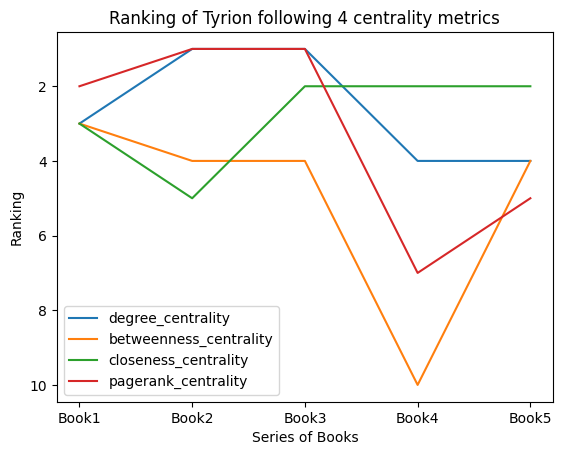

In [20]:
import matplotlib.pyplot as plt

books = ['Book1', 'Book2', 'Book3', 'Book4', 'Book5']

plt.plot(books, list_degree_centrality, label='degree_centrality')
plt.plot(books, list_betweenness_centrality, label='betweenness_centrality')
plt.plot(books, list_closeness_centrality, label='closeness_centrality')
plt.plot(books, list_pagerank, label='pagerank_centrality')


plt.gca().invert_yaxis()
plt.xlabel('Series of Books')
plt.ylabel('Ranking')
plt.title('Ranking of Tyrion following 4 centrality metrics')
plt.legend()

plt.show()

In the second book, "A Clash of Kings," Tyrion becomes the Hand of the King and gains more power and influence in King's Landing. This increased his degree centrality as he interacts with more characters in the network. Additionally, his pagerank centrality did also increase as he becomes a mediator between most characters and factions in the network.

In the third book, "A Storm of Swords," Tyrion's role and relationships change again. He is accused of a crime he did not commit ( murder of king Joeffrey Baratheon in the purple wedding), and many characters turn against him. This result in a decrease in his degree centrality as he interacts with fewer characters ( because he was a fugitive) in the network. Moreover, his betweenness centrality did also decrease as he loses his mediator role and becomes isolated from the network.

### Question 4 :

In [38]:
# Run the Label Propagation algorithm to detect communities
communities = nx.algorithms.community.label_propagation.label_propagation_communities(graph)

# Print the detected communities
for i, community in enumerate(communities):
    print(f"Community {i+1}: {community}")

Community 1: {'Skahaz-mo-Kandaq', 'Quaithe', 'Grazhar', 'Marselen', 'Steelskin', 'Larraq', 'Belwas', 'Meris', 'Rakharo', 'Hero', 'Eroeh', 'Lucifer-Long', 'Ezzara', 'Drogo', 'Jhiqui', 'Yurkhaz-zo-Yunzak', 'Bloodbeard', 'Ben-Plumm', 'Missandei', 'Xaro-Xhoan-Daxos', 'Barsena', 'Widower', 'Archibald-Yronwood', 'Cleon', 'Symon-Stripeback', 'Barristan-Selmy', 'Quentyn-Martell', 'Ghael', 'Aggo', 'Galazza-Galare', 'Gerris-Drinkwater', 'Groleo', 'Kedry', 'Lysono-Maar', 'Daario-Naharis', 'Caggo', 'Qezza', 'Khrazz', 'Jhogo', 'Miklaz', 'Tattered-Prince', 'Irri', 'Viserys-Targaryen', 'Denzo-Dhan', 'Daeron-II-Targaryen', 'Cletus-Yronwood', 'Draqaz', 'Marghaz-zo-Loraq', 'Hizdahr-zo-Loraq', 'Grey-Worm', 'Daenerys-Targaryen', 'Reznak-mo-Reznak', 'Mezzara', 'Old-Bill-Bone', 'Aegon-I-Targaryen'}
Community 2: {'Benerro', 'Ysilla', 'Rhaenys-Targaryen-(daughter-of-Rhaegar)', 'Lemore', 'Harry-Strickland', 'Petyr-Baelish', 'Qavo-Nogarys', 'Morgo', 'Shrouded-Lord', 'Yandry', 'Tyrion-Lannister', 'Aegon-Targarye

Community 1 reflecs characters involves with the Targaryen storyline and the city of Meereen.
Community 2 reflects the characters involved in Aegon Targaryen's storyline and their supporters.
Community 3 both characers here are deceased and related to the targaryen family, as one was in love with Ned stark
whom sister was secretly in a relation with the targaren prince who himself was married to Ellia Martell of Dorne
So this algorithm is more accurate than the two others.

In [36]:
from networkx.algorithms import community

# Detect communities using the Louvain algorithm
partition = community.greedy_modularity_communities(graph)

# Print the communities
for i, comm in enumerate(partition):
    print(f"Community {i+1}:")
    print(comm)
    print()


Community 1:
frozenset({'Melisandre', 'Wyman-Manderly', 'Rowan', 'Devan-Seaworth', 'Walda-Frey-(daughter-of-Merrett)', 'Clydas', 'Yellow-Dick', 'Willow-Witch-eye', 'Arya-Stark', 'Lyanna-Mormont', 'Denys-Mallister', 'Benethon-Scales', 'Gilly', 'Theomore', 'Aemon-Targaryen-(Maester-Aemon)', 'Luton', 'Ben-Bones', 'Ulmer', 'Donal-Noye', 'Axell-Florent', 'Godric-Borrell', 'Bran-Stark', 'Leona-Woolfield', 'Marlon-Manderly', 'Hosteen-Frey', 'Walder-Frey-(son-of-Jammos)', 'Roose-Bolton', 'Val', 'Theon-Greyjoy', 'Dalla', 'Owen', 'Rickon-Stark', 'Bartimus', 'Holly', 'Wex-Pyke', 'Maege-Mormont', 'Aenys-Frey', 'Kindly-Man', 'Mully', 'Joramun', 'Roose-Ryswell', 'Clayton-Suggs', 'Sansa-Stark', 'Corliss-Penny', 'Skinner', 'Ramsay-Snow', 'Marya-Seaworth', 'Qhorin-Halfhand', 'Azor-Ahai', 'Patchface', 'Grunt', 'Cotter-Pyke', 'Alys-Karstark', 'Frenya', 'Benjen-Stark', 'Sigorn', 'Harwood-Stout', 'Damon-Dance-for-Me', 'Selyse-Florent', 'Sour-Alyn', 'Stannis-Baratheon', 'Walder-Frey-(son-of-Merrett)', 'Sall

Most of communities are not real, as it includes characters who are dead, such as Melisandre, Roose Bolton, and Ygritte. Additionally, some of the characters listed are not known to have any direct association with each other, such as Wyman Manderly and Denys Mallister. Finally, the presence of characters like Azor Ahai, who is a legendary figure in the story, suggests that this community is more of a hypothetical grouping than a realistic one based on the events of the books.

In [37]:
# Apply the Girvan-Newman algorithm
communities_generator = nx.community.girvan_newman(graph)

# Get the top-level communities
top_level_communities = next(communities_generator)

# Print the community assignment for each node
for idx, community in enumerate(top_level_communities):
    print(f"Community {idx}: {community}")

Community 0: {'High-Sparrow', 'Marselen', 'Kerwin', 'Ashara-Dayne', 'Ysilla', 'Steelskin', 'Rhaenys-Targaryen-(daughter-of-Rhaegar)', 'Boros-Blount', 'Tytos-Blackwood', 'Balon-Swann', 'Mace-Tyrell', 'Jaime-Lannister', 'Hero', 'Eroeh', 'Petyr-Baelish', 'Tysha', 'Lucifer-Long', 'Arys-Oakheart', 'Nymeria-Sand', 'Elia-Martell', 'Yurkhaz-zo-Yunzak', 'Ben-Plumm', 'Xaro-Xhoan-Daxos', 'Sweets', 'Nurse', 'Harys-Swyft', 'Cleon', 'Meryn-Trant', 'Quentyn-Martell', 'Pono', 'Rodrik-Sparr', 'Lyanna-Stark', 'Jorah-Mormont', 'Gerris-Drinkwater', 'Wylis-Manderly', 'Daario-Naharis', 'Dunsen', 'Khrazz', 'Miklaz', 'Tattered-Prince', 'Malaquo-Maegyr', 'Daeron-II-Targaryen', 'Haldon', 'Myles-Toyne', 'Hugh-Hungerford', 'Yezzan-zo-Qaggaz', 'Belaquo', 'Penny', 'Hoster-Blackwood', 'Wulfe', 'Ralf-(Limper)', 'Qyburn', 'Kasporio', 'Trystane-Martell', 'Ronnet-Connington', 'Willam-Dustin', 'Jhiqui', 'Ellaria-Sand', 'Yandry', 'Widower', 'Archibald-Yronwood', 'Tyrion-Lannister', 'Symon-Stripeback', 'Barristan-Selmy', '

These characters are also not related to each beacuse some are from the North (such as Jon Snow and Bran Stark), the Iron Islands (such as Balon Greyjoy and Asha Greyjoy), the Riverlands (such as Walder Frey and Brynden Rivers), the Night's Watch (such as Samwell Tarly and Jeor Mormont), and even some characters from Essos (such as Melisandre and Salladhor Saan). These characters have different goals, loyalties, and motivations, and some of them are even enemies or have conflicting interests. This indicates that they are not all related to each other.

#  Machine Learning on Graphs

Next we will have a look at machine learning on graph networks. There are many types of learning targets depending on the level of the task, which are usually divided into:

* Graph-level prediction (e.g. molecule classification)
* Edge-level prediction (e.g. friend suggestions in social graphs)
* Node-level prediction (e.g. topic classification in citation networks)

![graph_tasks.jpg](https://drive.google.com/uc?id=1lIdvy_NXVLr7KhkM3afNgVDcokZ-BDy2)

Graphs contain an inherent structure and furthermore usually exhibit further attributes that constitute nodes and edges. The machine learning process on graphs is similar to learning on structured tabular data but comes with an important challenge:

* Feature engineering:  To work with machine learning algorithms, the graph structure and attributes must be converted into features that are helpful for solving the task at hand. Such features can be symbolic (for instance node degrees, clustering coefficients, path lengths) or sub-symbolic (node, edge, or graph embeddings). In the following, we will focus on the engineering of sub-symbolic features.

![graphml_process.jpg](https://drive.google.com/uc?id=1kAQQUE6sE75V1Y8i4uACzKfH6EjYBl8x)

The rest of the learning pipeline is essentially analogous to the one we know from Data Mining: We learn a model (which can be anything from a simple Decision Tree to Neural Networks) using the created features, improve it via parameter tuning using a clean evaluation setup and finally end up with a good model we can use for prediction.

### Graph Maching Learning with Pytorch-geometric

![pytorch-geo.jpg](https://drive.google.com/uc?id=1nu47e40yuVmgDwjZsIbwlfMkQ_4uRSpY)

[Pytorch-geometric](https://pytorch-geometric.readthedocs.io/en/latest/index.html) is a python library built on top of the vastly popular [Pytorch](https://pytorch.org/) library for building Deep Neural Networks of all kinds. The package offers constructs and methods specifically designed for handling graphs and related data, including:

* Data Handling of Graphs
* Data Transforms
* Mini-batching on Graphs
* Various pre-implemented Graph models and their layers

To use Pytorch-geometric, we first need to install Pytorch and subsequently the Pytorch-geometric package.

In [ ]:
# The following command installs Pytorch (CPU-only) via pip.
# If you are using Anaconda, we would recommend you install via conda using the command line

# to install via pip
# !pip3 install -U torch torchvision torchaudio
# !pip install -U torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

# OR

# use the following in an Anaconda Prompt (not in the notebook!) to install Pytorch via conda
# conda install pytorch torchvision torchaudio cpuonly -c pytorch

## Practical use-case of GraphML: Predicting Topics in citation networks

In this exercise we will have a look at node classification using various machine learning algorithms. For this we will make use of the popular CORA graph dataset, which consists of scientific publications represented as nodes and citations inbetween these publications as the edges of the graph.

Pytorch-geometric offers a dataset subpackage which we can use to easily load many popular graphs, for more information see [here](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html).

In [ ]:
from torch_geometric.datasets import Planetoid

# load the dataset using Pytorch-geometric
dataset = Planetoid(root='tmp/cora/', name="Cora")

In [ ]:
# Let's print some features of this dataset

print(f'Amount of graphs: {len(dataset)}')
print(f'Amount of classes/labels: {dataset.num_classes}')
print(f'Amount of node features: {dataset.num_node_features}')

In [ ]:
data = dataset[0]
data

In [ ]:
data.is_undirected()

We can see that the citation graph in the dataset contains 2708 nodes, each one having 1433 features. These 1433 features are a bag-of-words representation of each of the publications (see [here](https://ojs.aaai.org/aimagazine/index.php/aimagazine/article/view/2157)). There are 10.556/2 = 5.278 undirected edges between the nodes.

For each of the nodes a label (one of 7 topical domains) is available in the y attribute of the graph. Finally the dataset already contains predetermined training, validation and test splits to allow direct comparison with results from the original paper and other users. In the case of Graph Networks, these splits are provided as "masks" on the graph, meaning that when looking at the e.g. training portion of the graph, all labels for the validation and test portions are not considered. It is important to note, that even though labels are masked, the full graph is presented during training as well as testing.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# convert the graph to networkx for drawing
g = to_networkx(data, to_undirected=True)

fig = plt.figure(figsize=(20, 10))

# draw the graph
nx.draw_networkx(g, node_size=5, with_labels=False)

### Engineering node features with Node2Vec

For our first model, we will create some node-features using the node2vec method. This method takes inspiration from the popular Word2Vec model from the area of Natural Language Processing with the final embedding training being analogous. However, as the input to Word2Vec are sets of words from sentences selected by a sliding window, the authors of Node2Vec had to come up with a method of converting a graph into "sentences".

This is achieved by doing random walks over the graph starting from each node and then treating each of the walks as a "sentence" which can then be used as a training example for the skip-gram version of Word2Vec. In the implementation in Pytorch-geometric, the Node2Vec model further uses the negative sampling optimization process which was also used for training Word2Vec. This means that in every training step not all the weights of the network are changed but together with each "positive" example sentence a subset of negative "words" are sampled and during the backpropagation step only the weights of these selected input words are updated. In the case of Node2Vec that means not only "positive" random walks are sampled but each "positive" random walk is paired with a "negative" random walk for the purpose of negative sampling.

The Node2Vec model does not make use of any node features apart from the structural ones it creates using Random Walks. Of course it would possible to retrieve the learned embeddings and combine them with additional node features before applying a simple classifier.

![node2vec.jpg](https://drive.google.com/uc?id=1Lek4oxroisXHduYxp6RFzIPfTBzauvEF)

The following example applies the node2vec method to our graph to generate node embeddings which are subsequently used for training and evaluating a simple SVM classifier using scikit-learn.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import Node2Vec

# set to use either GPU if available or CPU if not
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# first define the model and hyperparamters
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=5,
                 context_size=5).to(device)

# prepare a dataloader and optimizer for training
loader = model.loader(batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)

In [ ]:
# Let us have a look at what one example in our data loader looks like
idx, (pos_rw, neg_rw) = next(enumerate(loader))

# index of the batch
print(idx)
# positive random walks in batch idx
print(pos_rw)
# associated negative random walks in batch idx
print(neg_rw)

In the following cell we select one of the random walks created and visualize it together with the graph

In [ ]:
edge_tuples = [tuple(x) for x in data.edge_index.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

Now let's start training the actual Node2Vec model. First, we need to define a training loop that iterates through the random walks, calculates the loss and backpropagates it through the model to update the weights. Afterwards we can loop through our desired number of epochs and train the Node2Vec model.

In [ ]:
# function that defines our training loop
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [ ]:
from tqdm.notebook import tqdm

# here we actually train the model
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

The model is trained, we can now extract the learned embedding for our nodes, convert them from Pytorch Tensors to numpy arrays, and subsequently use the familiar scikit-learn functionality to train an SVM classifier

In [ ]:
import numpy as np

# get the embeddings from the model
embeddings = model()

# convert sets to numpy arrays
train_x = embeddings[data.train_mask].detach().numpy()
train_y = data.y[data.train_mask].detach().numpy()

valid_x = embeddings[data.val_mask].detach().numpy()
valid_y = data.y[data.val_mask].detach().numpy()

full_train_x = np.concatenate((train_x, valid_x), axis=0)
full_train_y = np.concatenate((train_y, valid_y), axis=0)

test_x = embeddings[data.test_mask].detach().numpy()
test_y = data.y[data.test_mask].detach().numpy()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an instance of the SVC classifier
clf = SVC()

# Define a parameter grid for hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# Train the classifier using GridSearchCV on the training set
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_search.fit(full_train_x, full_train_y)

# Evaluate the classifier on the test set
y_pred = grid_search.predict(test_x)
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy on test set:", accuracy)

## End-to-End Learning with Graph Neural Networks

Instead of using fixed (pre-engineered) node features, we can instead leverage the power of deep learning and make use of Graph Neural Networks to learn feature representation over multiple stacking layers of a GNN with a final classification layer. This allows for the combined learning of feature embeddings as well as their classification at the same time, commonly referred to as end-to-end learning. We can either initialize the node embeddings randomly or use some pretrained values for initialization. Since the dataset already contains features for each node, we can directly use them as input.

We need to define the train/test loops for our models. We can make it generic so as to be able to use it with any model we design later on.

In [ ]:
from sklearn.metrics import accuracy_score

# the training method called every epoch
# get model output, calculate loss, backpropagate
def train(data, model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

# the evaluation method called every epoch
# get model output, compare with evaluation labels, save metrics if best validation loss since beginning training
@torch.no_grad()
def test(data, model):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = F.log_softmax(out, -1).argmax(dim=-1)
    
    accs = []
    losses = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        loss = F.cross_entropy(out[mask], data.y[mask])
        predictions = pred[mask].to('cpu')
        labels = data.y[mask].to('cpu')
        acc = accuracy_score(labels, predictions)
        losses.append(loss)
        accs.append(acc)

    return (losses, accs)

# the actual looping thorugh epochs and calling of the above two functions
def train_test_loop(data, model, optimizer):
    best_val_loss = 9999

    for epoch in range(1,101):
        loss = train(data, model, optimizer)
        (train_loss, val_loss, test_loss), (train_acc, val_acc, test_acc) = test(data, model)
        if epoch == 1:
            best_test_acc = 0
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_test_acc = test_acc

        log(Epoch=f'{epoch:02d}', Loss=f'{loss:.4f}', Train=f'{train_acc:.4f}', Val=f'{val_acc:.4f}', Test=f'{test_acc:.4f}')
    print(f'\nTest Accuracy in best validation Epoch: {best_test_acc}')

In the following example, we will use a Graph Convolutional Network (GCN) to learn node embeddings and subsequently classify them. We can directly use a preimplemented GCN model or we can build one layer-wise ourselves. In this example we will use the preimplemented [GCN](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GCN.html#torch_geometric.nn.models.GCN) model. Let us first use randomly initialized embeddings for the nodes, which means we do not make use of the node features, i.e. the BOW representations.

In [ ]:
from copy import deepcopy

# make a copy of the graph and replace the node embeddings with randomly initialized ones
data_random = deepcopy(data)
data_random.x = torch.randn_like(data_random.x)

In [ ]:
from torch_geometric.logging import log
from torch_geometric.nn.models import GCN

# prepare the model and the optimizer
model = GCN(in_channels=dataset.num_node_features, hidden_channels=128,
            out_channels=dataset.num_classes, num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# call our train/test loop and start training
train_test_loop(data_random, model, optimizer)

The GCN can significantly improve over the results of the Node2Vec+SVM combination. Now, let us use the actual available node features for initialization instead to see if this brings further improvement.

In [ ]:
# prepare the model and the optimizer
model = GCN(in_channels=dataset.num_node_features, hidden_channels=128, out_channels=dataset.num_classes, num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# call our train/test loop and start training
train_test_loop(data, model, optimizer)

Clearly initializing the embeddings with node-related knowledge significantly improves the results the GCN can achieve, indicating that learning only the structure of the graph is not sufficient.

Pytorch-geometric offers many more GNN models you can try out-of-the-box. In the following we will train a Graph Attention Network ([GAT](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAT.html#torch_geometric.nn.models.GAT)) which leverages the self-attention mechanism that also powers the highly successful Transformer architecture in Natural Language Processing. Compared to the simple GCN, the GAT gives each node the ability to weight the incoming messages from other nodes differently and can put higher attention towards important messages.

In [ ]:
from torch_geometric.nn.models import GAT

model = GAT(in_channels=dataset.num_node_features, hidden_channels=128, out_channels=dataset.num_classes, num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

train_test_loop(data, model, optimizer)

You can find some student projects that were implemented using Pytorch-geometric [here](https://medium.com/stanford-cs224w) (these could give you some ideas if you want to use GNNs for your own projects, e.g. it is also possible to implement a recommendation system with GNNs and compare it to the "tradtional" approaches in Surprise).